Binomial distribution: maximum entropy when each trial must result in one of two events and the expected value is constant

Logistic regression: 0/1 target


Aggregated bionmial regression: [0,n] target, number of successes in n trials

Possion regression
Multinomial logistic regression


In [69]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [4]:
chimps = pd.read_csv('./data/chimpanzees.csv', sep=';')

In [6]:
chimps.columns

Index(['actor', 'recipient', 'condition', 'block', 'trial', 'prosoc_left',
       'chose_prosoc', 'pulled_left'],
      dtype='object')

In [8]:
chimps.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [10]:
chimps.actor.unique()

array([1, 2, 3, 4, 5, 6, 7])

In [12]:
chimps.condition.unique()

array([0, 1])

We want to study if a condition makes choosing prosoc option more likely. aka the interaction between chose_prosoc and 
condition

Four kind of treatments:

In [28]:
chimps['treatment'] = chimps.prosoc_left + 2 * chimps.condition

In [29]:
with pm.Model() as m1:
    a = pm.Normal("a", 0.0, 10.0)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=chimps.pulled_left)
    m1_trace = pm.sample_prior_predictive()

In [30]:
m1_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

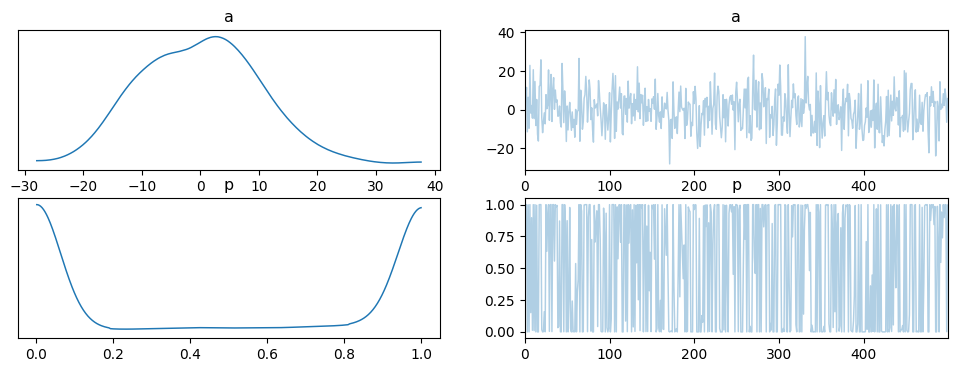

In [31]:
az.plot_trace(m1_trace.prior)

So the p is the prior probability of pulling the left lever. This is too much assumption for a prior.

In [32]:
with pm.Model() as m2:
    a = pm.Normal("a", 0.0, 0.5)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=chimps.pulled_left)
    m2_trace = pm.sample_prior_predictive()

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

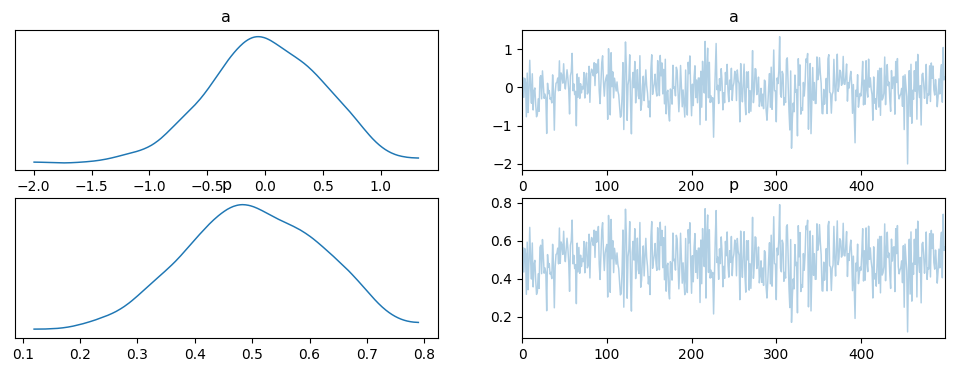

In [33]:
az.plot_trace(m2_trace.prior)

In [34]:
with pm.Model() as m3:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 10, shape=4)
    p = pm.Deterministic("p", pm.math.invlogit(a + b[chimps.treatment]))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=chimps.pulled_left)
    m3_trace = pm.sample_prior_predictive()

array([[<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

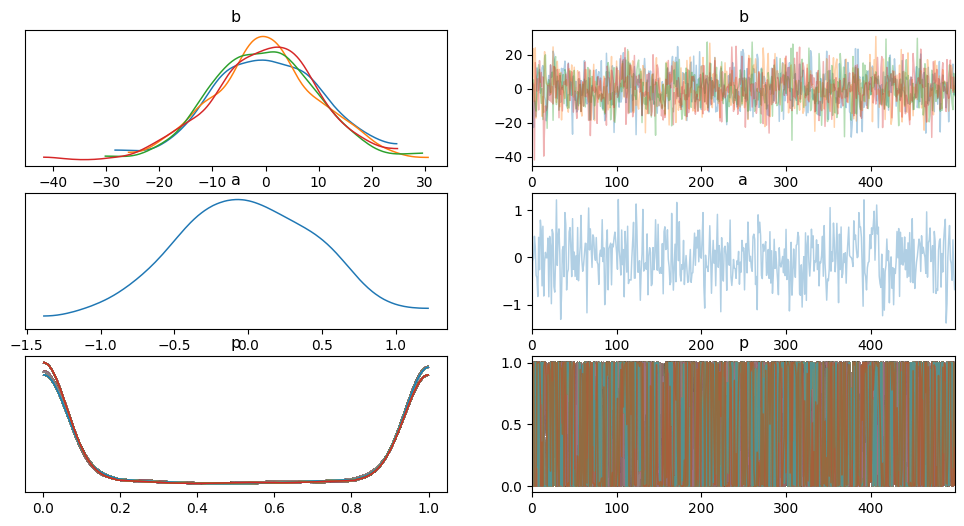

In [36]:
az.plot_trace(m3_trace.prior)

So again we went back to saturating the extremes. In the book they plot the differece between treatments which may be infered from
these posteriors

In [72]:
with pm.Model() as m4:
    a = pm.Normal("a", 0.0, 1.5)
    b = pm.Normal("b", 0.0, 0.5, shape=4)
    p = pm.Deterministic("p", pm.math.invlogit(a + b[chimps.treatment]))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=chimps.pulled_left)
    m4_trace = pm.sample_prior_predictive()

array([[<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

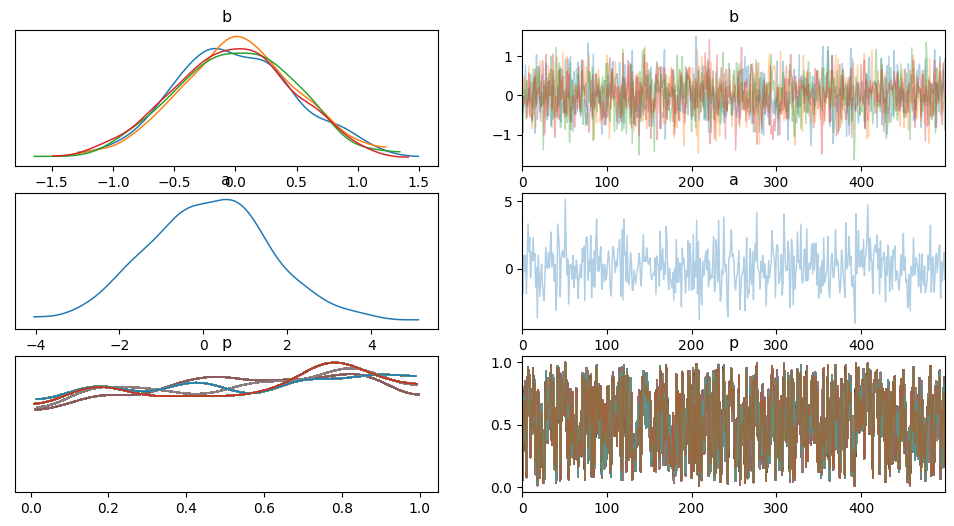

In [73]:
az.plot_trace(m4_trace.prior)

Let's get a sense of the prior difference between things that shouldn't be different like left vs right side, under the same
prosoc condition.

chimps['treatment'] = chimps.prosoc_left + 2 * chimps.condition

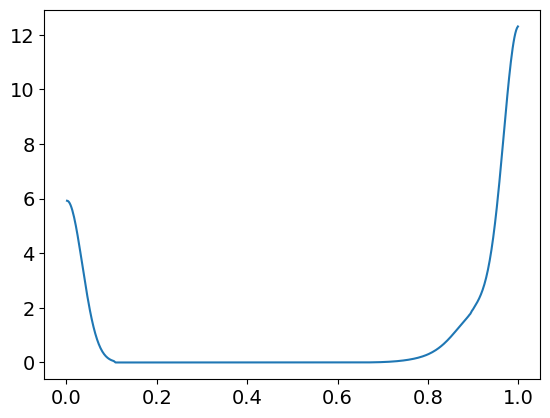

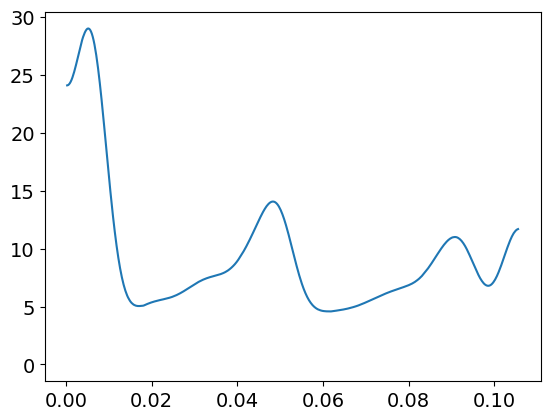

In [82]:
from scipy.special import expit as logistic

for trace in [m3_trace, m4_trace]:
    betas = trace.prior['b'][:,2]
    t1 = logistic((trace.prior['a'] + betas).to_numpy())
    betas = trace.prior['b'][:,3]
    t2 = logistic((trace.prior['a'] + betas).to_numpy())
    plt.figure()
    az.plot_dist([np.abs(t1-t2),])

In [87]:
chimps.actor=chimps.actor-1

In [92]:
with pm.Model() as m5:
    a = pm.Normal("a", 0.0, 1.5, shape=7)
    b = pm.Normal("b", 0.0, 0.5, shape=4)
    p = pm.Deterministic("p", pm.math.invlogit(a[chimps.actor] + b[chimps.treatment]))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=chimps.pulled_left)
    m5_posterior_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [93]:
az.summary(m5_posterior_trace, var_names=["a", "b"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.46,0.34,-1.07,0.19,0.01,0.01,1706.06,2750.96,1.00
a[1],3.86,0.73,2.63,5.41,0.01,0.01,4190.12,2832.48,1.00
a[2],-0.76,0.34,-1.41,-0.12,0.01,0.01,1631.62,2650.24,1.00
a[3],-0.76,0.34,-1.37,-0.11,0.01,0.01,1729.36,2524.81,1.00
a[4],-0.46,0.34,-1.12,0.13,0.01,0.01,1424.13,2676.54,1.00
a[5],0.47,0.34,-0.16,1.11,0.01,0.01,1567.15,2290.67,1.00
a[6],1.94,0.41,1.14,2.68,0.01,0.01,1997.08,2755.34,1.00
b[0],-0.03,0.29,-0.60,0.49,0.01,0.01,1360.39,1925.77,1.01
b[1],0.49,0.29,-0.04,1.05,0.01,0.01,1443.89,2265.10,1.00
b[2],-0.37,0.29,-0.89,0.20,0.01,0.01,1439.58,2540.42,1.00


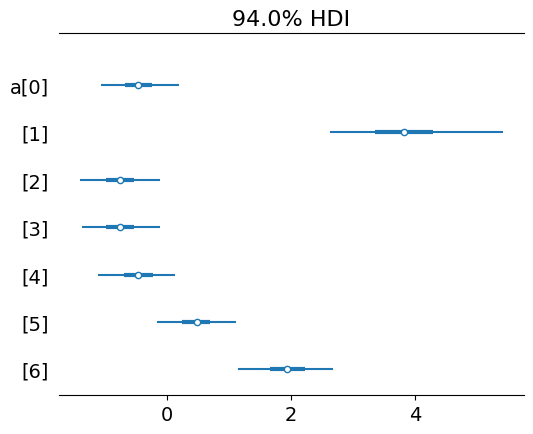

In [97]:
az.plot_forest(m5_posterior_trace, var_names=["a"], transform=logistic, combined=True);


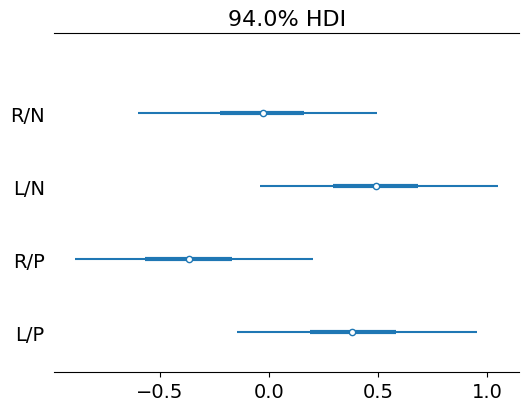

In [120]:
ax = az.plot_forest(m5_posterior_trace,
               var_names=["b"],
               combined=True);

ax[0].set_yticklabels(list(reversed(["R/N", "L/N", "R/P", "L/P"])));

#chimps['treatment'] = chimps.prosoc_left + 2 * chimps.condition

In [119]:
So the four treatments tells us which is the option with two foods (left or right) and if there was another chimp or not
in the trial. We would like to see that when the chimp is present, they choose the prosoc option.

[3, 2, 1]

In the above plot we want positive differences (pulling right more, less left, when partner in experiment
and food on right). In the plot below we want negative differences (pulling left more, when partner in experiment
and food on left). Definetely is not the case in the plot on top, and only a slight effect in the plot at bottom.

<AxesSubplot:>

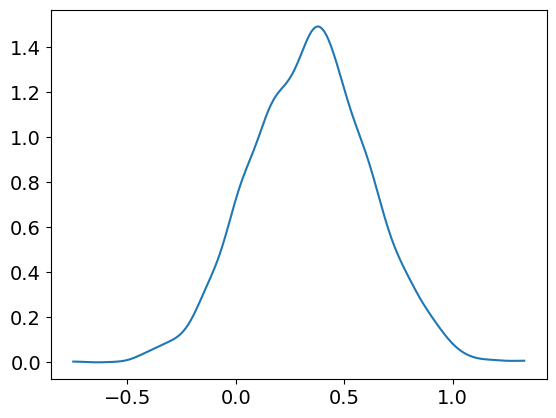

In [124]:
az.plot_dist(m5_posterior_trace.posterior.sel(b_dim_0=0)['b'] - m5_posterior_trace.posterior.sel(b_dim_0=2)['b'])

<AxesSubplot:>

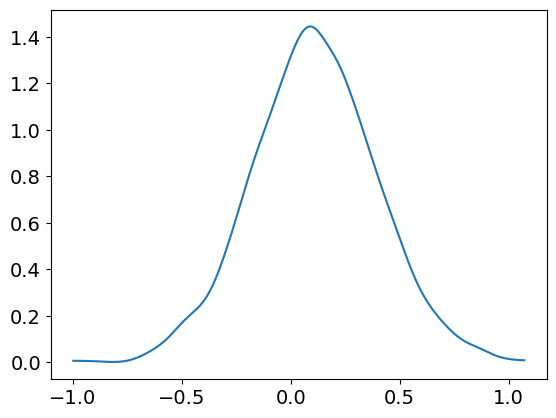

In [125]:
az.plot_dist(m5_posterior_trace.posterior.sel(b_dim_0=1)['b'] - m5_posterior_trace.posterior.sel(b_dim_0=3)['b'])

# Posterior prediction check

A not so beautifull but far quicker version of the plot in page 333. The second actor is fine, is just that it always triggers
the same lever and for some reason that's not displayed

Text(0.5, 1.0, 'Observed difference when food on left side')

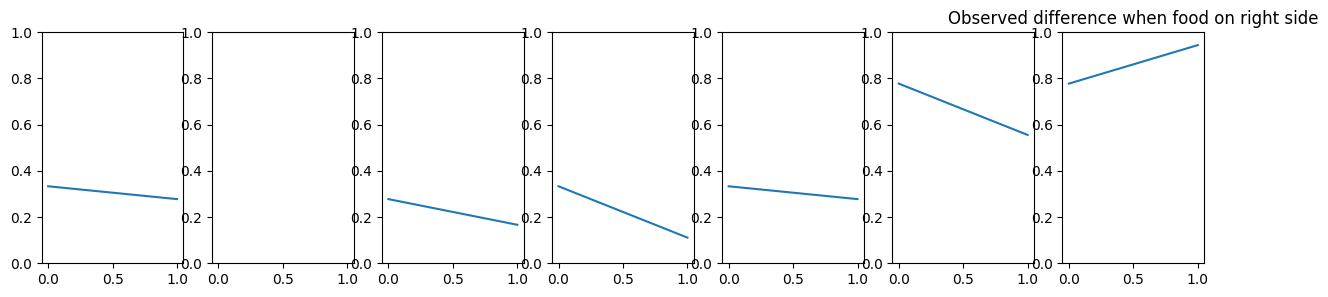

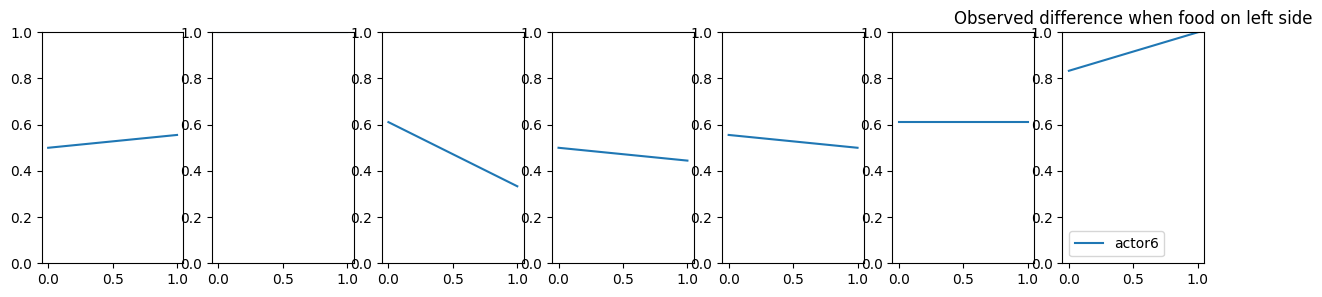

In [171]:
chimps.groupby(['actor', 'treatment']).sum()
diffs_by_actor = []
fig, ax = plt.subplots(1,7, figsize=(15,3))
plt.title('Observed difference when food on right side')
for actor in range(0, 7):

    df = chimps[chimps.actor == actor].groupby('treatment').mean()
    ax[actor].plot([df.iloc[0]['pulled_left'], df.iloc[2]['pulled_left']], label=f'actor{actor}')
    ax[actor].set_ylim((0,1))
    #df.iloc[1]['pulled_left'] - df.iloc[3]['pulled_left']))


fig, ax = plt.subplots(1,7, figsize=(15,3))
for actor in range(0, 7):
    df = chimps[chimps.actor == actor].groupby('treatment').mean()
    ax[actor].plot([df.iloc[1]['pulled_left'], df.iloc[3]['pulled_left']], label=f'actor{actor}')
    ax[actor].set_ylim((0,1))


    #df.iloc[1]['pulled_left'] - df.iloc[3]['pulled_left']))
plt.legend()
plt.title('Observed difference when food on left side')

Let's now look at the models implied predictions

In [183]:
with pm.Model() as m5_with_interventions:
    actors = pm.MutableData("actor", chimps.actor)
    treatments = pm.MutableData("treatment", chimps.treatment)

    a = pm.Normal("a", 0.0, 1.5, shape=7)
    b = pm.Normal("b", 0.0, 0.5, shape=4)
    p = pm.Deterministic("p", pm.math.invlogit(a[actors] + b[treatments]))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=chimps.pulled_left)
    m5_with_interventions_posterior_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [185]:
with m5_with_interventions:
    pm.set_data({"actor": np.repeat(range(7), 4), "treatment": list(range(4)) * 7})
    ppd = pm.sample_posterior_predictive(m5_with_interventions_posterior_trace, var_names=["p"])[
        "posterior_predictive"
    ]["p"]
p_mu = np.array(ppd.mean(["chain", "draw"])).reshape((7, 4))

Text(0.5, 1.0, 'Observed difference when food on left side')

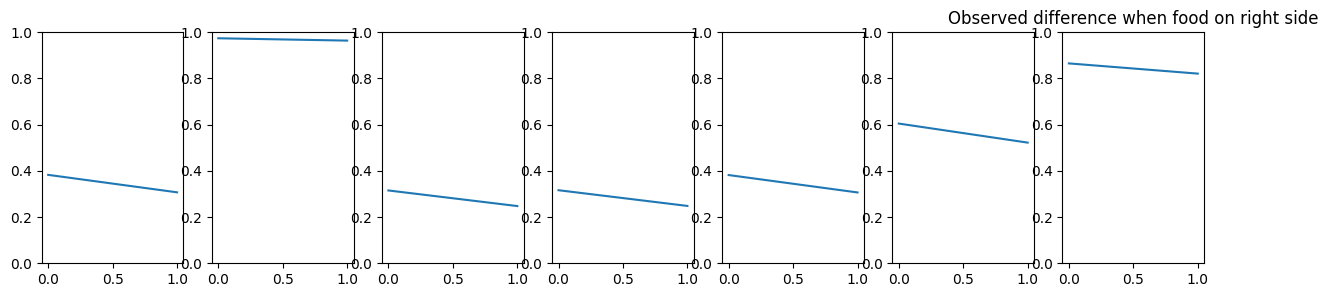

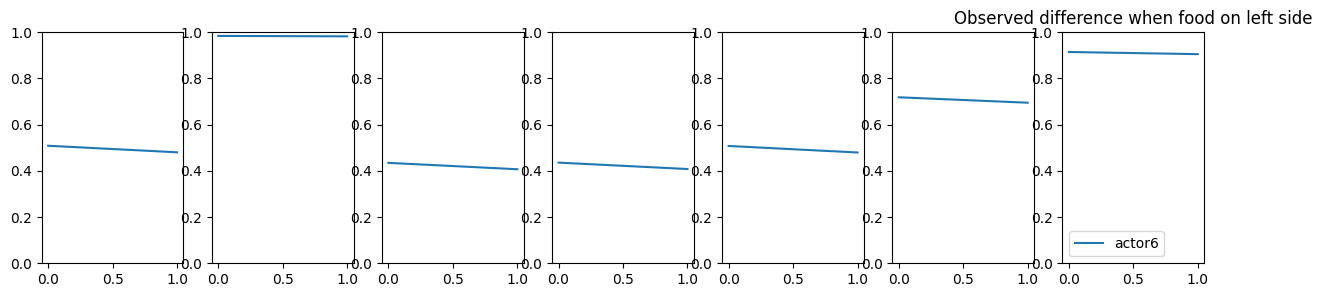

In [188]:
chimps.groupby(['actor', 'treatment']).sum()
diffs_by_actor = []
fig, ax = plt.subplots(1,7, figsize=(15,3))
plt.title('Observed difference when food on right side')
for actor in range(0, 7):

    ax[actor].plot([p_mu[actor, 0], p_mu[actor, 2]], label=f'actor{actor}')
    ax[actor].set_ylim((0,1))
    #df.iloc[1]['pulled_left'] - df.iloc[3]['pulled_left']))


fig, ax = plt.subplots(1,7, figsize=(15,3))
for actor in range(0, 7):
    ax[actor].plot([p_mu[actor, 1], p_mu[actor, 3]], label=f'actor{actor}')
    ax[actor].set_ylim((0,1))


    #df.iloc[1]['pulled_left'] - df.iloc[3]['pulled_left']))
plt.legend()
plt.title('Observed difference when food on left side')

In [189]:
az.compare({"m5": m5_posterior_trace, "m4": m4_posterior_trace})


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m5,0,-266.086375,8.437309,0.000000,1.000000e+00,9.452078,0.000000,False,log
m4,1,-341.241946,3.636983,75.155571,4.280309e-11,4.577547,9.185719,False,log


# Aggregated binomial (section 11.1.3)

In [206]:
agg_chimps = chimps.groupby(['actor', 'treatment'], as_index=False).agg({'pulled_left': sum, 'trial': 'count'})

In [209]:
agg_chimps.trial.unique()

array([18])

In [210]:
with pm.Model() as m6_with_interventions:
    actors = pm.MutableData("actor", agg_chimps.actor)
    treatments = pm.MutableData("treatment", agg_chimps.treatment)
    a = pm.Normal("a", 0.0, 1.5, shape=7)
    b = pm.Normal("b", 0.0, 0.5, shape=4)
    p = pm.Deterministic("p", pm.math.invlogit(a[actors] + b[treatments]))
    pulled_left = pm.Binomial("pulled_left",18 , p, observed=agg_chimps.pulled_left)
    m6_with_interventions_posterior_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [212]:
az.compare({"m5": m5_with_interventions_posterior_trace, "m6": m6_with_interventions_posterior_trace})


/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


ValueError: The number of observations should be the same across all models

In [ ]:
This is a totally correct warning, is what we expected.

In [214]:
az.loo(m5_with_interventions_posterior_trace)


Computed from 4000 posterior samples and 504 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -266.07     9.46
p_loo        8.45        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      504  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [215]:
az.loo(m6_with_interventions_posterior_trace)


/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 posterior samples and 28 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -57.06     4.15
p_loo        8.35        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       20   71.4%
 (0.5, 0.7]   (ok)          6   21.4%
   (0.7, 1]   (bad)         2    7.1%
   (1, Inf)   (very bad)    0    0.0%

Recall that bad k values mean that there are leverage/influential points. This has the rationale that in M5 a point is just a trial
but in m6 a point is a full actor, so is like calcualting leave-18-out.

In [216]:
az.waic(m5_with_interventions_posterior_trace)

Computed from 4000 posterior samples and 504 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -266.05     9.46
p_waic        8.43        -

In [217]:
az.waic(m6_with_interventions_posterior_trace)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 posterior samples and 28 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -56.26     3.99
p_waic        7.54        -

There has been a warning during the calculation. Please check the results.

Analogous result for waic.

# 11.1.4 Aggregate binomial: graduate school admisions

In [219]:
applications = pd.read_csv('./data/UCBadmit.csv', sep=';')

In [220]:
applications.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [222]:
applications['index_gender'] = applications['applicant.gender'].apply(lambda x: 0 if x == 'male' else 1)

In [229]:
with pm.Model() as graduate_m1:
    gender = applications['index_gender']
    alpha = pm.Normal('alpha', 0, 1.5, shape=2)
    acceptance_rate = pm.Deterministic('acceptance_rate', pm.math.invlogit(alpha[gender]))
    admissions = pm.Binomial('admissions',
                             applications['applications'],
                             acceptance_rate,
                             observed=applications['admit'])
    graduate_m1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [230]:
az.summary(graduate_m1_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.221,0.039,-0.295,-0.147,0.001,0.000,3480.0,2856.0,1.0
alpha[1],-0.829,0.050,-0.919,-0.735,0.001,0.001,3981.0,2971.0,1.0
acceptance_rate[0],0.445,0.010,0.427,0.463,0.000,0.000,3480.0,2856.0,1.0
acceptance_rate[1],0.304,0.011,0.285,0.324,0.000,0.000,3981.0,2971.0,1.0
acceptance_rate[2],0.445,0.010,0.427,0.463,0.000,0.000,3480.0,2856.0,1.0
acceptance_rate[3],0.304,0.011,0.285,0.324,0.000,0.000,3981.0,2971.0,1.0
acceptance_rate[4],0.445,0.010,0.427,0.463,0.000,0.000,3480.0,2856.0,1.0
acceptance_rate[5],0.304,0.011,0.285,0.324,0.000,0.000,3981.0,2971.0,1.0
acceptance_rate[6],0.445,0.010,0.427,0.463,0.000,0.000,3480.0,2856.0,1.0
acceptance_rate[7],0.304,0.011,0.285,0.324,0.000,0.000,3981.0,2971.0,1.0


Text(0.5, 1.0, 'Contrast between male and female, in outcome scale')

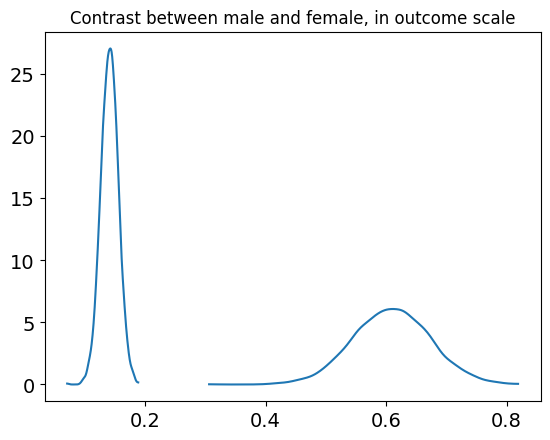

In [336]:
az.plot_dist(graduate_m1_trace.posterior['alpha'][:,:,0] - graduate_m1_trace.posterior['alpha'][:,:,1])
plt.title('Contrast between male and female, in logit scale')

az.plot_dist(logistic(graduate_m1_trace.posterior['alpha'][:,:,0].to_numpy()) - logistic(graduate_m1_trace.posterior['alpha'][:,:,1].to_numpy()) )
plt.title("Contrast between male and female, in outcome scale")

Text(0.5, 1.0, 'Contrast between male and female, in outcome scale')

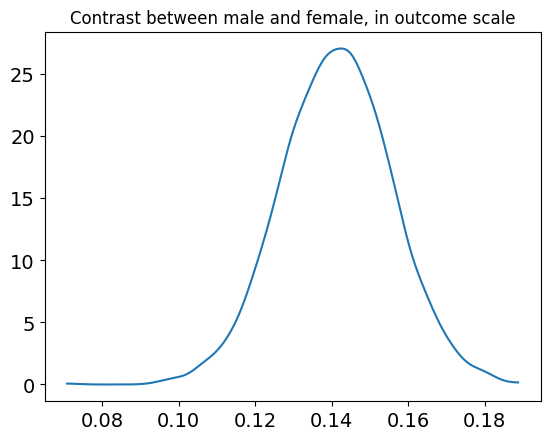

In [246]:
az.plot_dist(logistic(graduate_m1_trace.posterior['alpha'][:,:,0].to_numpy()) - logistic(graduate_m1_trace.posterior['alpha'][:,:,1].to_numpy()) )
plt.title("Contrast between male and female, in outcome scale")

So it seems in both scales that males are more likely to get accepted overall.

Posterior checks

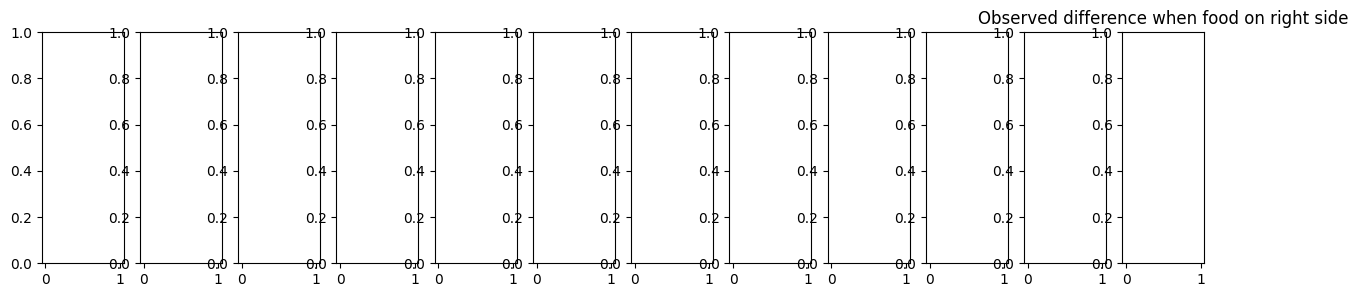

In [263]:
observed_applications.loc[[('A',0)]]

,,admit
dept,index_gender,
A,0,512


In [274]:
grouped_applications = applications.groupby(['dept', 'index_gender']).sum()

admit  reject  applications
dept index_gender                             
A    0               512     313           825
     1                89      19           108
B    0               353     207           560
     1                17       8            25
C    0               120     205           325
     1               202     391           593
D    0               138     279           417
     1               131     244           375
E    0                53     138           191
     1                94     299           393
F    0                22     351           373
     1                24     317           341

In [278]:

#nasty but quick mapping
m = {'A':0, 'B':1, 'C':2, 'D':3, 'E': 4 ,'F':5}
applications['index_dept'] = applications.dept.apply(lambda x: m[x])

In [279]:
grouped_applications = applications.groupby(['index_dept', 'index_gender']).sum()

In [281]:
grouped_applications['acceptance_rate'] = grouped_applications['admit'] / grouped_applications['applications']

In [294]:
grouped_applications.loc[(0,0), :]

admit              512.000000
reject             313.000000
applications       825.000000
acceptance_rate      0.620606
Name: (0, 0), dtype: float64

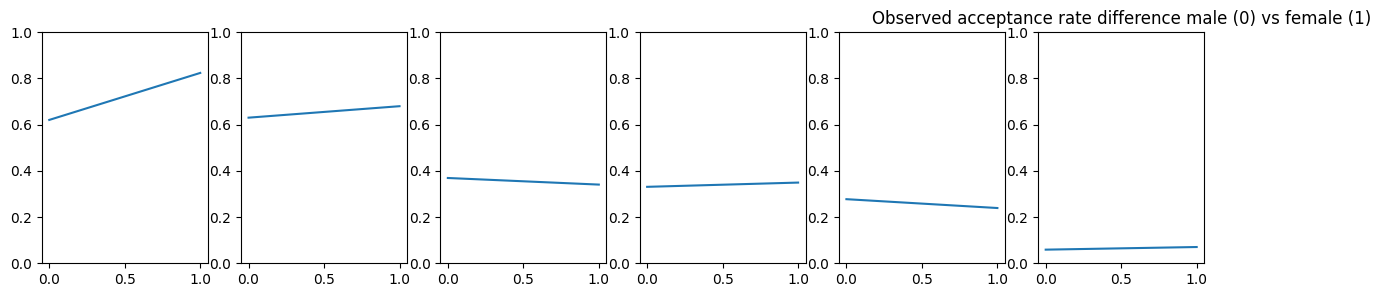

In [297]:
fig, ax = plt.subplots(1,6, figsize=(15,3))
plt.title('Observed acceptance rate difference male (0) vs female (1)')
for department in range(0, 6):
    ax[department].set_ylim((0,1))
    ax[department].plot([grouped_applications.loc[(department,0), 'acceptance_rate'],
                         grouped_applications.loc[(department,1), 'acceptance_rate']])
    #df.iloc[1]['pulled_left'] - df.iloc[3]['pul3led_left']))


# fig, ax = plt.subplots(1,7, figsize=(15,3))
# for actor in range(0, 7):
#     ax[actor].plot([p_mu[actor, 1], p_mu[actor, 3]], label=f'actor{actor}')
#     ax[actor].set_ylim((0,1))


#     #df.iloc[1]['pulled_left'] - df.iloc[3]['pulled_left']))
# plt.legend()
# plt.title('Observed difference when food on left side')

In [300]:
with graduate_m1:
    
    ppc = pm.sample_posterior_predictive(graduate_m1_trace,  var_names=["admissions", "acceptance_rate"])
#    pp_p = ppc["posterior_predictive"]["p"]
#    pp_admit = ppc["posterior_predictive"]["admit"] / d_ad.applications.values[None, :]


# p_mu = np.array(pp_p.mean(["chain", "draw"]))
# p_std = np.array(pp_p.std(["chain", "draw"]))
# admit_mu = np.array(pp_admit.mean(["chain", "draw"]))
# admit_std = np.array(pp_admit.std(["chain", "draw"]))

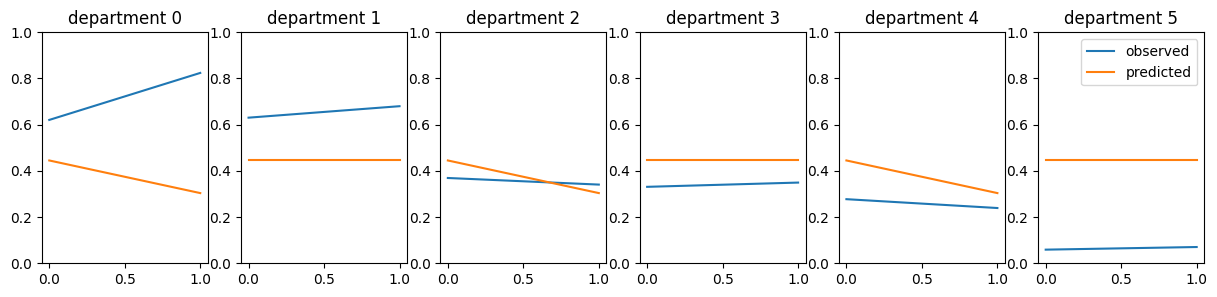

In [329]:
pp_p = ppc["posterior_predictive"]["acceptance_rate"]
p_mu = np.array(pp_p.mean(["chain", "draw"]))

fig, ax = plt.subplots(1,6, figsize=(15,3))
plt.title('Observed acceptance rate difference male (0) vs female (1)')
for department in range(0, 6):
    ax[department].set_ylim((0,1))
    ax[department].plot([grouped_applications.loc[(department,0), 'acceptance_rate'],
                         grouped_applications.loc[(department,1), 'acceptance_rate']], label='observed')
    ax[department].plot([p_mu[department*2],p_mu[department+1]], label='predicted')
    ax[department].set_title(f'department {department}')
plt.legend()
    
    #df.iloc[1]['pulled_left'] - df.iloc[3]['pul3led_left']))


# fig, ax = plt.subplots(1,7, figsize=(15,3))
# for actor in range(0, 7):
#     ax[actor].plot([p_mu[actor, 1], p_mu[actor, 3]], label=f'actor{actor}')
#     ax[actor].set_ylim((0,1))


#     #df.iloc[1]['pulled_left'] - df.iloc[3]['pulled_left']))
# plt.legend()
# plt.title('Observed difference when food on left side')

So deparments 2 and 4 are the only ones where women had a lower acceptance rate, but the model consistely predicts 
is going to be lower.

In [334]:
with pm.Model() as graduate_m2:
    gender = applications['index_gender']
    department = applications['index_dept']
    alpha = pm.Normal('alpha', 0, 1.5, shape=2)
    delta = pm.Normal('delta', 0, 1.5, shape=6)
    acceptance_rate = pm.Deterministic('acceptance_rate', pm.math.invlogit(alpha[gender] + delta[department]))
    admissions = pm.Binomial('admissions',
                             applications['applications'],
                             acceptance_rate,
                             observed=applications['admit'])
    graduate_m2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, delta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.6775, but should be close to 0.8. Try to increase the number of tuning steps.


In [335]:
az.summary(graduate_m2_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.498,0.555,-1.526,0.540,0.031,0.022,343.0,390.0,1.02
alpha[1],-0.401,0.556,-1.423,0.650,0.031,0.022,346.0,403.0,1.02
delta[0],1.078,0.557,0.004,2.073,0.031,0.022,343.0,385.0,1.02
delta[1],1.034,0.560,-0.052,2.039,0.031,0.022,343.0,431.0,1.02
delta[2],-0.180,0.558,-1.188,0.890,0.031,0.022,346.0,414.0,1.02
delta[3],-0.214,0.557,-1.249,0.820,0.031,0.022,349.0,428.0,1.02
delta[4],-0.657,0.560,-1.731,0.352,0.031,0.024,351.0,433.0,1.02
delta[5],-2.210,0.568,-3.309,-1.173,0.031,0.023,345.0,438.0,1.02
acceptance_rate[0],0.641,0.016,0.610,0.668,0.000,0.000,5011.0,3598.0,1.00
acceptance_rate[1],0.663,0.022,0.623,0.706,0.000,0.000,4748.0,2973.0,1.00


Text(0.5, 1.0, 'Contrast between male and female, in logit scale')

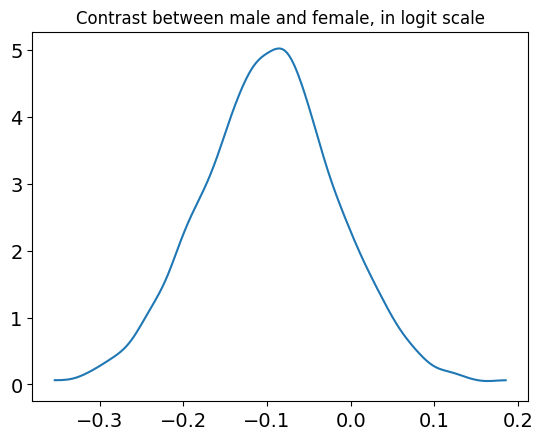

In [340]:
az.plot_dist(graduate_m2_trace.posterior['alpha'][:,:,0] - graduate_m2_trace.posterior['alpha'][:,:,1])
plt.title('Contrast between male and female, in logit scale')

Text(0.5, 1.0, 'Contrast between male and female, in outcome scale')

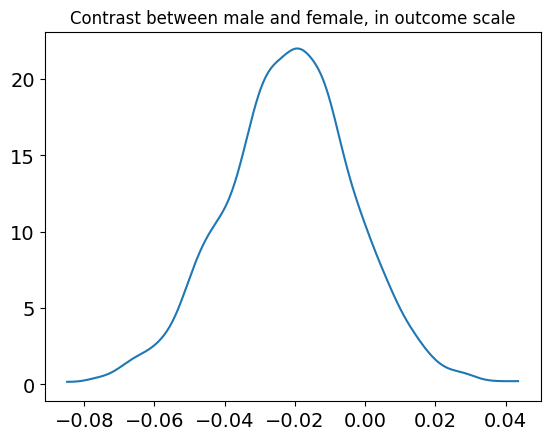

In [341]:
az.plot_dist(logistic(graduate_m2_trace.posterior['alpha'][:,:,0].to_numpy()) - logistic(graduate_m2_trace.posterior['alpha'][:,:,1].to_numpy()) )
plt.title("Contrast between male and female, in outcome scale")

# Possion regression

When then binomial N is big and p is small it tends to a process where mean and variance are the same, the poisson distribution

Using log link fuction we get a positive parameter, at the same time we buy an exponential relationship between predictor
and outcome to be taken into account when doing prior and posterior checks. It is important to run this simulations
to really check the consecuences throught the possible value range.

In [352]:
kline = pd.read_csv('./data/Kline2.csv', sep=',')

In [353]:
kline.head()

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235


Intuition:
contact and log population increase total_tools
big + with contact help more, aka we want an interaction there.

Let's first try to find sensible priors.

In [363]:
with pm.Model() as kline_m1:
    alpha = pm.Normal('alpha', 0, 10)
    lamda = pm.Deterministic('lmbda', pm.math.exp(alpha))
    tools = pm.Poisson('tools', lamda, observed=kline.total_tools)
    prior = pm.sample_prior_predictive()
    
    
with pm.Model() as kline_m2:
    alpha = pm.Normal('alpha', 3, 0.5)
    lamda = pm.Deterministic('lmbda', pm.math.exp(alpha))
    tools = pm.Poisson('tools', lamda, observed=kline.total_tools)
    prior_m2 = pm.sample_prior_predictive()

<AxesSubplot:>

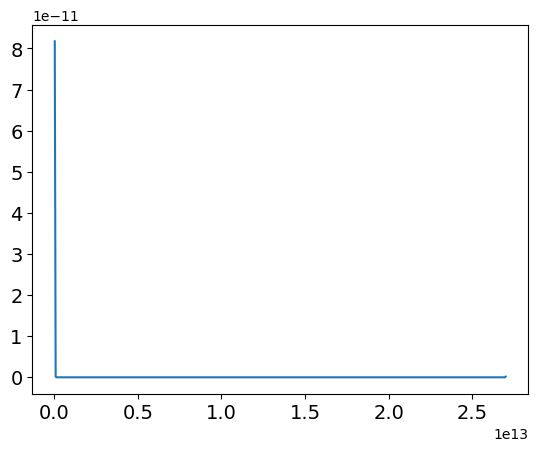

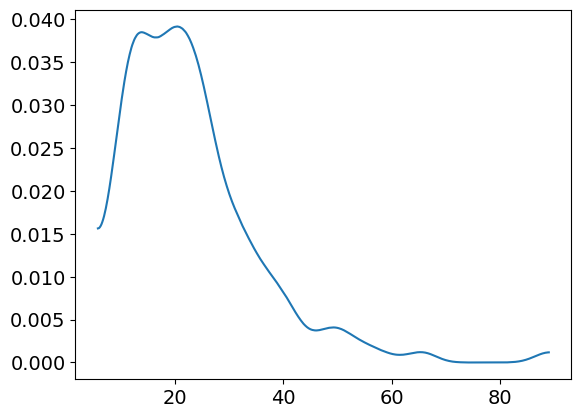

In [365]:
az.plot_dist(prior.prior['lmbda'])
plt.figure()
az.plot_dist(prior_m2.prior['lmbda'])

So the first prior has as mean an insane number of tools, which make no sense. Moreover, there'a  a lot of mass around 0 The second prior has less tail + not so much mass round 0.

In [426]:
def contact_to_idx(contact):
    if contact == 'low':
        return 0
    if contact == 'high':
        return 1
    else:
        raise ValueError(f"unknown contact{contact}")
    
kline['contact_idx'] = kline['contact'].apply(contact_to_idx)
kline['standarized_logpop'] = (kline["logpop"] - np.mean(kline["logpop"])) / np.std(kline["logpop"])

In [427]:
# this is taking the suggestion from https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_11.ipynb
#p = (kline["logpop"] - np.mean(kline["logpop"])) / np.std(kline["logpop"])
#kline['standarized_logpop'] =  p + np.abs(p.min()) + 0.1  # must be > 0

<AxesSubplot:>

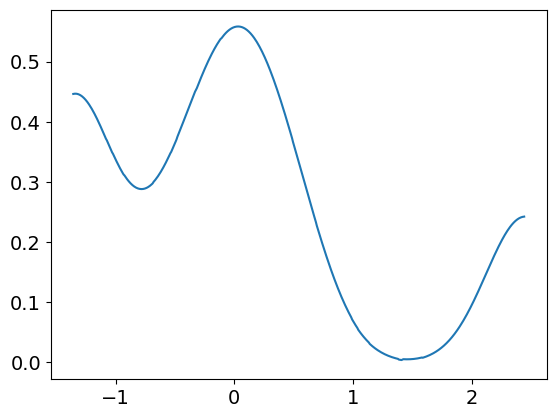

In [428]:
az.plot_dist(kline['standarized_logpop'])

In [492]:
with pm.Model() as kline_m3:
    contact_idx = kline['contact_idx']
    standarized_log_pop = kline['standarized_logpop']
    
    contact_idx = pm.MutableData('contact_idx', contact_idx)
    standarized_log_pop = pm.MutableData('standarized_log_pop', standarized_log_pop)

    alpha = pm.Normal('alpha', 3, 0.5, shape=2)
    beta = pm.Normal('beta', 0, 0.2, shape=2)
    
    lamda = pm.Deterministic('lmbda', pm.math.exp(alpha[contact_idx] + (beta[contact_idx] * standarized_log_pop)))
    
    tools = pm.Poisson('tools', lamda, observed=kline.total_tools)
    prior_m3 = pm.sample_prior_predictive()

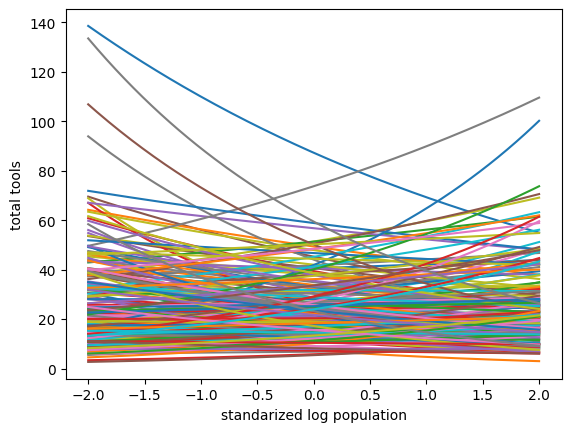

In [494]:
for d in range(0,200):
    x_axis = np.linspace(-2,2, 200)
    plt.plot(x_axis, np.exp((np.squeeze(prior_m3.prior['alpha'][:,:,0]) + prior_m3.prior['beta'][:,:,0].T * x_axis))[d])
    plt.ylabel('total tools')
    plt.xlabel('standarized log population')

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


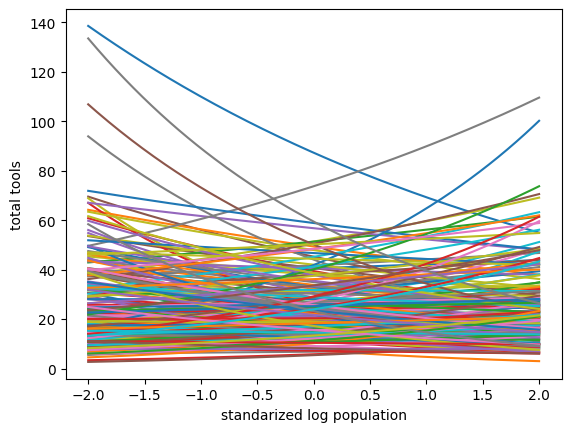

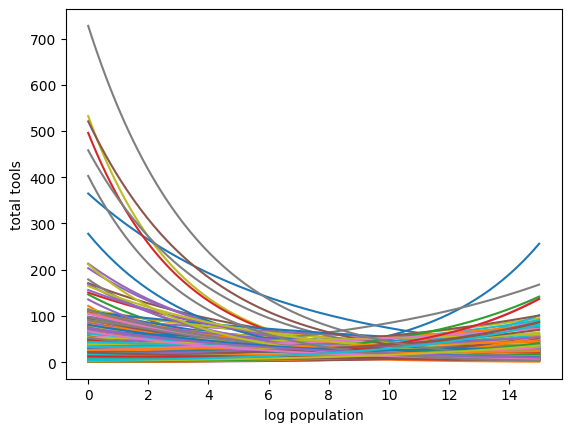

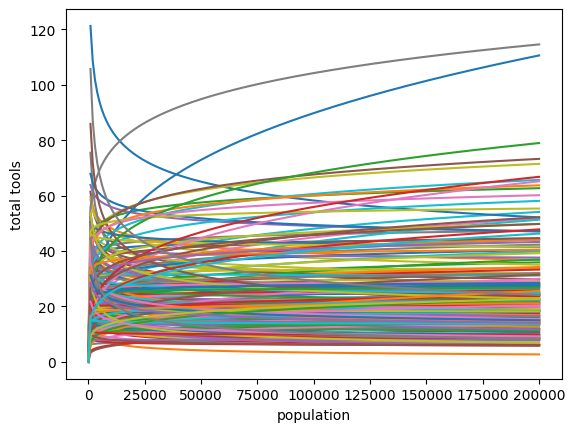

In [495]:
m = np.mean(kline["logpop"])
s = np.std(kline["logpop"])
plt.figure()
for d in range(0,200):
    x_axis = np.linspace(-2,2, 200)
    plt.plot(x_axis, np.exp((np.squeeze(prior_m3.prior['alpha'][:,:,0]) + prior_m3.prior['beta'][:,:,0].T * x_axis))[d])
    plt.ylabel('total tools')
    plt.xlabel('standarized log population')


plt.figure()
for d in range(0,200):
    x_axis = np.linspace(0, 15, 200)
    x=(x_axis - m) /s
    plt.plot(x_axis , np.exp((np.squeeze(prior_m3.prior['alpha'][:,:,0]) + prior_m3.prior['beta'][:,:,0].T * x))[d])
    plt.ylabel('total tools')
    plt.xlabel('log population')

plt.figure()
for d in range(0,200):
    x_axis = np.linspace(0, 200000, 200)
    x=(np.log(x_axis) - m) / s
    plt.plot(x_axis , np.exp((np.squeeze(prior_m3.prior['alpha'][:,:,0]) + prior_m3.prior['beta'][:,:,0].T * x))[d])
    plt.ylabel('total tools')
    plt.xlabel('population')




In [496]:
with kline_m3:
    posterior_m3 = pm.sample()
    
with pm.Model() as kline_m3_bis:
    contact_idx = kline['contact_idx']
    standarized_log_pop = kline['standarized_logpop']

    alpha = pm.Normal('alpha', 3, 0.5, shape=2)
    
    lamda = pm.Deterministic('lmbda', pm.math.exp(alpha[contact_idx]))
    
    tools = pm.Poisson('tools', lamda, observed=kline.total_tools)
    posterior_m3_bis = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [497]:
az.compare({'slope+intercept': posterior_m3, 'only_intercept': posterior_m3_bis})

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
slope+intercept,0,-42.874721,7.284882,0.000000,1.000000e+00,6.210160,0.000000,True,log
only_intercept,1,-75.379133,17.342988,32.504412,8.526513e-14,22.752043,21.737719,True,log


In [498]:
az.waic(posterior_m3)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -41.89     6.10
p_waic        6.30        -

There has been a warning during the calculation. Please check the results.

In [499]:
az.waic(posterior_m3_bis)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -74.73    22.48
p_waic       16.70        -

There has been a warning during the calculation. Please check the results.

In [500]:
az.loo(posterior_m3)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -42.87     6.21
p_loo        7.28        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        8   80.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1   10.0%
   (1, Inf)   (very bad)    1   10.0%

In [501]:
az.loo(posterior_m3_bis)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -75.38    22.75
p_loo       17.34        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        7   70.0%
 (0.5, 0.7]   (ok)          2   20.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1   10.0%

- seccond model has bigger number of effective parameters
- first model 

In simple linear models, model complexity and parameter count have clear link. Once we have more structure, the link is not so clear. Overfitting depends on the strcuture of the data and of the model.

In [502]:
k = az.loo(posterior_m3, pointwise=True).pareto_k.values
kline['pareto'] = k

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Text(0.5, 1.0, 'Total tools vs log standarized population')

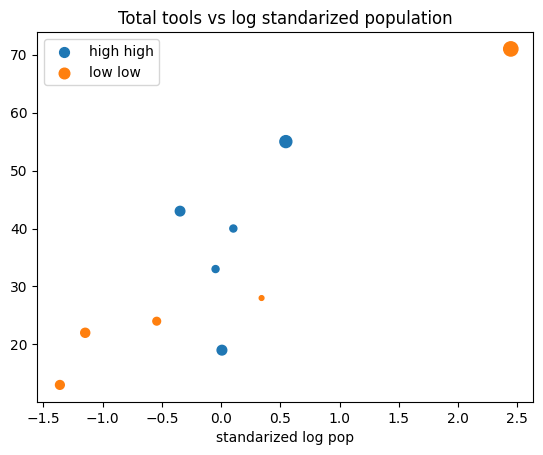

In [503]:
for contact in ('high', 'low'):
    to_plot = kline[kline.contact == contact]
    plt.scatter(to_plot['standarized_logpop'], to_plot['total_tools'], s=to_plot['pareto']*100, label=f"{contact} {contact}")
plt.legend()
plt.xlabel('standarized log pop')
plt.title('Total tools vs log standarized population')

Text(0.5, 1.0, 'Total tools vs population')

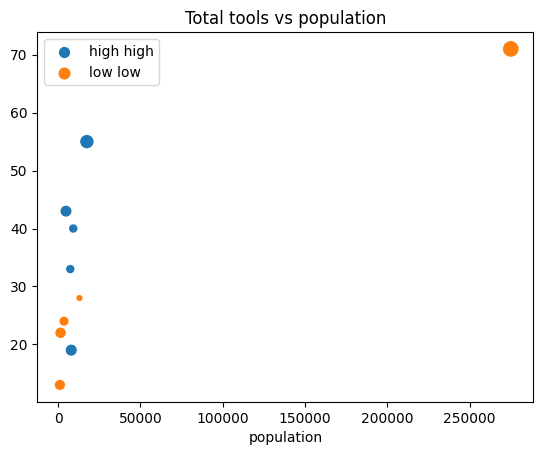

In [504]:
for contact in ('high', 'low'):
    to_plot = kline[kline.contact == contact]
    plt.scatter(to_plot['population'], to_plot['total_tools'], s=to_plot['pareto']*100, label=f"{contact} {contact}")
plt.legend()
plt.xlabel('population')
plt.title('Total tools vs population')

In [505]:
kline[['culture', 'pareto']]

,culture,pareto
0,Malekula,0.399679
1,Tikopia,0.424964
2,Santa Cruz,0.308033
3,Yap,0.472910
4,Lau Fiji,0.252677
5,Trobriand,0.484961
6,Chuuk,0.256657
7,Manus,0.115219
8,Tonga,0.741637
9,Hawaii,1.055519


In this fit I don't get exactly the same pareto as in the book, although the ones >0.7 are the same.

In [527]:
ns=200
with kline_m3:
    simulated_standarized_log_p = np.linspace(-3,3,ns)
    pm.set_data({"contact_idx": np.array([0] * ns), "standarized_log_pop": simulated_standarized_log_p})

    lam0 = pm.sample_posterior_predictive(posterior_m3, var_names=["tools"])[
        "posterior_predictive"
    ]["tools"]

    pm.set_data({"contact_idx": np.array([1] * ns)})
    lam1 = pm.sample_posterior_predictive(posterior_m3, var_names=["tools"])[
        "posterior_predictive"
    ]["tools"]



Text(0.5, 1.0, 'Total tools vs log standarized population')

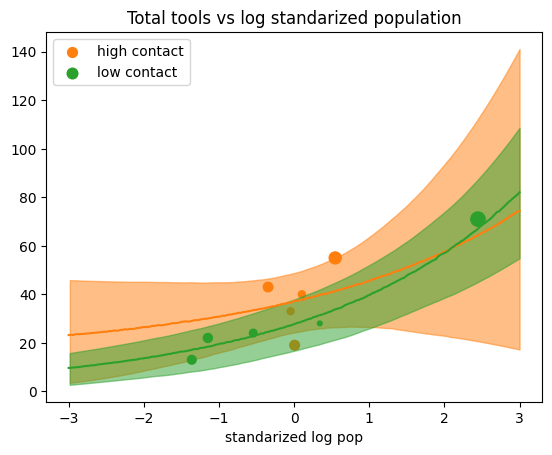

In [531]:
for contact, pp, color in [('high', lam1, 'C1'), ('low', lam0, 'C2')]:
    to_plot = kline[kline.contact == contact]
    plt.scatter(to_plot['standarized_logpop'], to_plot['total_tools'], s=to_plot['pareto']*100, label=f"{contact} contact", color=color)

    az.plot_hdi(simulated_standarized_log_p, pp, color=color)
    plt.plot(simulated_standarized_log_p, pp.mean(["chain","draw"]), color=color)
    
plt.legend()
plt.xlabel('standarized log pop')
plt.title('Total tools vs log standarized population')

eventually high contact is below low contact, since the model doesn't know any high contact high population
cases. A theoretical high contact hawai should have more tools or the same, but not less than it actually has

Multinomial and categorical models

In [534]:
from scipy.special import softmax
n = 500
income_per_career = np.array([1,2,5])
scores = income_per_career * 0.5
p = softmax(scores)
p

array([0.09962365, 0.16425163, 0.73612472])

In [543]:
careers = np.random.choice([0,1,2], p=p, size=n)

In [ ]:
with pm.Model() as multinomial_m1:
    s = np.zeros(3)
    
    _p = pm.Determinisitc('p', pm.math.softmax(s))
    career = pm.Categorical('career'_p)